# Node identifier: Autoencoder, reconstruction error approach

## Preparation

### Load data

In [1]:
# Import packages
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import *
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [2]:
# Load train and test set
path = 'C:/Users/User/Desktop/Assignatures/Synthesis project/GraphAnomaly/dades_arnau/'

In [3]:
# Use sequential split
with open(path + 'sequential_train.pkl', 'rb') as f:
    train_seq = pickle.load(f)
with open(path + 'sequential_test.pkl', 'rb') as f:
    test_seq = pickle.load(f)

In [4]:
from Helper import split_labels_classes

# Separate data by classes and labels
X_ilicit, y_ilicit, X_licit, y_licit, X_unknown, y_unknown, test_ilicit_X, test_ilicit_y, test_licit_X, test_licit_y, test_unknown_X, test_unknown_y  = split_labels_classes(train_seq, test_seq)

### Preparate data for the model

In [5]:
class CustomDataset(Dataset):
    def __init__(self, X):
        self.X = X        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):        
        return self.X[idx] 

In [6]:
# Create dataloaders for each data set
licit_train = CustomDataset(torch.tensor(X_licit.values, dtype=torch.float32))
ilicit_train = CustomDataset(torch.tensor(X_ilicit.values, dtype=torch.float32))
unknown_train = CustomDataset(torch.tensor(X_unknown.values, dtype=torch.float32)) 
licit_test = CustomDataset(torch.tensor(test_licit_X.values, dtype=torch.float32))
ilicit_test = CustomDataset(torch.tensor(test_ilicit_X.values, dtype=torch.float32)) 
unknown_test = CustomDataset(torch.tensor(test_unknown_X.values, dtype=torch.float32)) 

licit_train_loader = DataLoader(licit_train, batch_size=128, shuffle=True)
licit_test_loader = DataLoader(licit_test, batch_size=128, shuffle=False)
ilicit_train_loader = DataLoader(ilicit_train, batch_size=128, shuffle=False)
ilicit_test_loader = DataLoader(ilicit_test, batch_size=128, shuffle=False)
unknown_train_loader = DataLoader(unknown_train, batch_size=128, shuffle=False)
unknown_test_loader = DataLoader(unknown_test, batch_size=128, shuffle=False)

## Autoencoder

### Model definition

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 200),
            nn.Tanh(),
            nn.Linear(200, encoding_dim),
            nn.Tanh(),
            nn.Linear(encoding_dim, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, encoding_dim),
            nn.Tanh(),
            nn.Linear(encoding_dim, 200),
            nn.Tanh(),
            nn.Linear(200, input_dim),
            nn.ReLU()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
def train_ae(autoencoder, train_loader, val_loader, criterion, optimizer, num_epochs=10): 
    total_train_loss = [] 
    total_validation_loss = []

    for epoch in range(num_epochs):
        autoencoder.train()
        running_loss = 0.0
        for inputs in train_loader:
            optimizer.zero_grad()
            
            # Forward pass
            outputs = autoencoder(inputs)
            
            # Compute the loss
            loss = criterion(outputs, inputs)
            loss = loss / 1_000
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}")
        total_train_loss.append(train_loss)
        
        #validació dins del mateix train loop
        validation_loss = val_ae(autoencoder=autoencoder, data_loader=val_loader, criterion=criterion)
        print(f"Validation Loss: {validation_loss:.4f}")
        total_validation_loss.append(validation_loss)
    return total_train_loss, total_validation_loss

def val_ae(autoencoder, data_loader, criterion):
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs in data_loader:
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            loss = loss / 1_000
            val_loss += loss.item()
    epoch_loss = val_loss / len(data_loader.dataset)
    return epoch_loss


### Training 

In [46]:
# Hyperparameters
lr = 0.001
EPOCHS = 20

input_dim = X_licit.shape[1]
model = Autoencoder(input_dim=input_dim,encoding_dim=300)
criterion = nn.CrossEntropyLoss()  # Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

training_loss, validation_loss = train_ae(autoencoder=model, train_loader=licit_train_loader, criterion=criterion, 
                                          optimizer=optimizer, val_loader=licit_test_loader, num_epochs=EPOCHS)
torch.save(model.state_dict(), path + 'ae_rloss.pth')

Epoch [1/20], Training Loss: 143.5699
Validation Loss: 0.8007
Epoch [2/20], Training Loss: 0.9837
Validation Loss: 0.3174
Epoch [3/20], Training Loss: 0.4595
Validation Loss: 0.1793
Epoch [4/20], Training Loss: 0.2741
Validation Loss: 0.1177
Epoch [5/20], Training Loss: 0.1847
Validation Loss: 0.0849
Epoch [6/20], Training Loss: 0.1340
Validation Loss: 0.0637
Epoch [7/20], Training Loss: 0.1016
Validation Loss: 0.0523
Epoch [8/20], Training Loss: 0.0798
Validation Loss: 0.0424
Epoch [9/20], Training Loss: 0.0653
Validation Loss: 0.0371
Epoch [10/20], Training Loss: 0.0538
Validation Loss: 0.0306
Epoch [11/20], Training Loss: 0.0441
Validation Loss: 0.0273
Epoch [12/20], Training Loss: 0.0383
Validation Loss: 0.0254
Epoch [13/20], Training Loss: 0.0337
Validation Loss: 0.0228
Epoch [14/20], Training Loss: 0.0298
Validation Loss: 0.0215
Epoch [15/20], Training Loss: 0.0267
Validation Loss: 0.0202
Epoch [16/20], Training Loss: 0.0241
Validation Loss: 0.0189
Epoch [17/20], Training Loss: 0

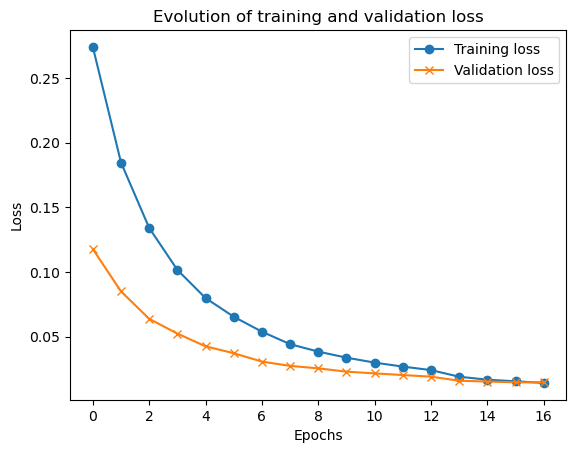

In [47]:
# Sample data: evolution of two lists over time
list1 = training_loss[3:]
list2 = validation_loss[3:]
time_points = range(len(list1))  # Assuming both lists have the same length

# Create a figure and axis
fig, ax = plt.subplots()

# Plot both lists
ax.plot(time_points, list1, label='Training loss', marker='o')
ax.plot(time_points, list2, label='Validation loss', marker='x')

# Add titles and labels
ax.set_title('Evolution of training and validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

# Add a legend
ax.legend()

# Show the plot
plt.show()

### Test results

In [9]:
def infer_ae(loader, autoencoder, criterion, msg):
    autoencoder.eval() 
    loss_history = []
    total_loss = 0     

    with torch.no_grad():
        for inputs in loader:
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            loss = loss / 1_000
            total_loss += loss.item()
            loss_history.append(float(loss))
    total_loss /= len(loader.dataset)    
    print(msg + str(round(total_loss,4)))    
    return total_loss, loss_history

In [12]:
# Define the path to the saved model
model_path = path + 'ae_rloss.pth'
# Create an instance of your model
model = Autoencoder(input_dim, encoding_dim=300)
# Load the state_dict into the model
model.load_state_dict(torch.load(model_path))

criterion = nn.CrossEntropyLoss()

licit_train, _ = infer_ae(licit_train_loader, model, criterion, 'Train Licit Loss: ')
licit_test, licit_loss = infer_ae(licit_test_loader, model, criterion, 'Test Licit Loss: ')
ilicit_train = infer_ae(ilicit_train_loader, model, criterion, 'Train Ilicit Loss: ')
ilicit_test, ilicit_loss = infer_ae(ilicit_test_loader, model, criterion, 'Test Ilicit Loss: ')
unknown_train = infer_ae(unknown_train_loader, model, criterion, 'Train Unknown Loss: ')
unknown_test, unknown_loss = infer_ae(unknown_test_loader, model, criterion, 'Test Unknown Loss: ')

Train Licit Loss: 0.014
Test Licit Loss: 0.0146
Train Ilicit Loss: 0.0111
Test Ilicit Loss: 0.0114
Train Unknown Loss: 0.0094
Test Unknown Loss: 0.0114


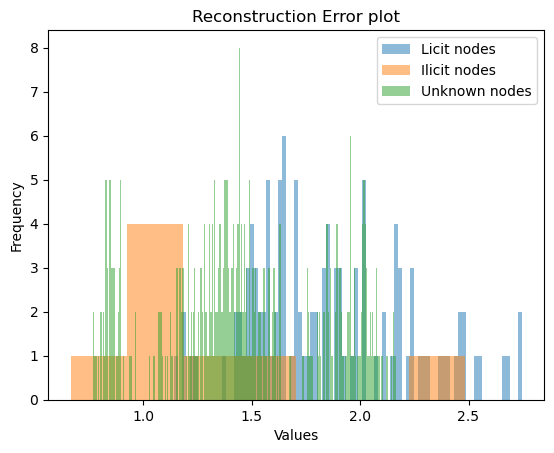

In [15]:
# Determine the range of values in both lists
min_value = min(min(licit_loss), min(ilicit_loss), min(unknown_loss))
max_value = max(max(licit_loss), max(ilicit_loss), max(unknown_loss))

# Plot histograms for all lists
plt.hist(licit_loss, bins=len(licit_loss), alpha=0.5, label='Licit nodes', range=(min_value, max_value))
plt.hist(ilicit_loss, bins=len(ilicit_loss), alpha=0.5, label='Ilicit nodes', range=(min_value, max_value))
plt.hist(unknown_loss, bins=len(unknown_loss), alpha=0.5, label='Unknown nodes', range=(min_value, max_value))

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Reconstruction Error plot')

# Add legend
plt.legend()

# Show the plot
plt.show()